In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scikitplot as skplt
import sklearn
from sklearn.model_selection import train_test_split
import os

# Helper Functions

In [17]:
def normalize_volume(volume):
    return (volume-volume.min())/(volume.max()-volume.min())

def _get_path(radius, level, i):
    if level == 'normal':
        return r'A:\MSc\Pulmonary Nodules\sameslicethickness\normal_cropped_lower_quality' + '/v' + str(i) + '.npy'
    else :
        return r'A:\MSc\Pulmonary Nodules\sameslicethickness\arranged\radius_' + str(radius) + '\level_' + str(level) + '/v' + str(i) + '.npy'
    
def get_training_data(radius, n = 1000, size = (64,64,28), levels=['normal', 1, 5], criteria = 'mixed'):
    h,w,d = size
    
    data = []
    label = []
    
    if criteria == 'mixed': # normal vs mix malignant and benign volumes (labeled as "contain nodules")
        level = levels[0]
        for i in tqdm(range(n)):
            try:
                data.append(normalize_volume(np.load(_get_path(radius, level, i))).reshape(h,w,d,1))
                label.append(0)
            except:
                continue
        
        level = levels[1]
        for i in tqdm(range(int(n/2))):
            try:
                data.append(normalize_volume(np.load(_get_path(radius, level, i))).reshape(h,w,d,1))
                label.append(1)
            except:
                continue
                
        level = levels[2]
        for i in tqdm(range(int(n/2))):
            try:
                data.append(normalize_volume(np.load(_get_path(radius, level, i))).reshape(h,w,d,1))
                label.append(1)
            except:
                continue
            
        
    elif criteria == 'binary' : # normal vs malignant or normal vs benign
        for level in levels:
            for i in tqdm(range(n)):
                try:
                    data.append(normalize_volume(np.load(_get_path(radius, level, i))).reshape(h,w,d,1))
                except :
                    continue
                if level == 'normal':
                    label.append(0)
                else :
                    label.append(1)
    
    elif criteria == 'binary_nodules': # malignant vs benign
        for level in levels:
            for i in tqdm(range(n)):
                try:
                    data.append(normalize_volume(np.load(_get_path(radius, level, i))).reshape(h,w,d,1))
                except :
                    continue
                if level == 1:
                    label.append(0)
                elif level == 5 :
                    label.append(1)
    
    elif criteria == 'three classes': # three classes for classification normal vs ben vs mal
        for level in levels:
            for i in tqdm(range(n)):
                try:
                    data.append(normalize_volume(np.load(_get_path(radius, level, i))).reshape(h,w,d,1))
                except :
                    continue
                if level == 'normal':
                    label.append(0)
                elif level == 1 :
                    label.append(1)
                elif level == 5 :
                    label.append(2)
        
    return data, label

def data_prep(data, labels, BATCH_SIZE = 32, SHUFFLE_BUFFER_SIZE = 100, n_classes = 1):
    train_ds, valid_ds, y_train, y_valid = train_test_split(data, labels, test_size=0.2, random_state=42)
    print("number of training examples: ", len(train_ds))
    print("number of validation examples: ", len(valid_ds))
    
    if n_classes == 3:
        y_train = tf.keras.utils.to_categorical(y_train, 3)
        y_valid = tf.keras.utils.to_categorical(y_valid, 3)

    train_dataset = tf.data.Dataset.from_tensor_slices((train_ds, y_train))
    validation_dataset = tf.data.Dataset.from_tensor_slices((valid_ds, y_valid))

    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)
    
    
    return train_dataset, validation_dataset

def get_cnn_model(h=64,w=64,d=28,n_classes=1):
    
    if n_classes == 1:

        model = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape=(h,w,d, 1)),
            tf.keras.layers.Conv3D(16, 5, padding='same', activation='relu'),
            tf.keras.layers.Conv3D(16, 5, padding='same', activation='relu'),
            tf.keras.layers.Conv3D(32, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling3D(),
            tf.keras.layers.Conv3D(32, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv3D(32, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv3D(64, 1, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling3D(),
            tf.keras.layers.Conv3D(64, 1, padding='same', activation='relu'),
            tf.keras.layers.Conv3D(64, 1, padding='same', activation='relu'),
            tf.keras.layers.Conv3D(128, 1, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling3D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(n_classes, activation='sigmoid')
        ])
    else :
        
        model = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape=(h,w,d, 1)),
            tf.keras.layers.Conv3D(16, 5, padding='same', activation='relu'),
            tf.keras.layers.Conv3D(16, 5, padding='same', activation='relu'),
            tf.keras.layers.Conv3D(32, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling3D(),
            tf.keras.layers.Conv3D(32, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv3D(32, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv3D(64, 1, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling3D(),
            tf.keras.layers.Conv3D(64, 1, padding='same', activation='relu'),
            tf.keras.layers.Conv3D(64, 1, padding='same', activation='relu'),
            tf.keras.layers.Conv3D(128, 1, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling3D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(n_classes, activation='softmax')
        ])
    return model

# Data Preparation

## Normal vs Malignant

### Normal vs Malignant (radius = 10)

In [19]:
# variables
r = 10
l = ['normal', 5]
c = 'binary'
n_classes = 1
model_name = 'normal_vs_malignant_r10'
bs = 16
epochs = 20
# Done

### Normal vs Malignant (radius = 20)

In [32]:
# variables
r = 20
l = ['normal', 5]
c = 'binary'
n_classes = 1
model_name = 'normal_vs_malignant_r20'
bs = 16
epochs = 20
# done

### Normal vs Malignant (radius = 30)

In [37]:
# variables
r = 30
l = ['normal', 5]
c = 'binary'
n_classes = 1
model_name = 'normal_vs_malignant_r30'
bs = 16
epochs = 20
# done

### Normal vs Malignant (radius = 40)

In [42]:
# variables
r = 40
l = ['normal', 5]
c = 'binary'
n_classes = 1
model_name = 'normal_vs_malignant_r40'
bs = 16
epochs = 20
# done

### Normal vs Malignant (radius = 50)

In [47]:
# variables
r = 50
l = ['normal', 5]
c = 'binary'
n_classes = 1
model_name = 'normal_vs_malignant_r50'
bs = 16
epochs = 20
# done

## Normal vs Benign

### Normal vs Benign (radius = 10)

In [52]:
# variables
r = 10
l = ['normal', 1]
c = 'binary'
n_classes = 1
model_name = 'normal_vs_benign_r10'
bs = 16
epochs = 20
# done

### Normal vs benign (radius = 20)

In [57]:
# variables
r = 20
l = ['normal', 1]
c = 'binary'
n_classes = 1
model_name = 'normal_vs_benign_r20'
bs = 16
epochs = 20
# done

### Normal vs benign (radius = 30)

In [62]:
# variables
r = 30
l = ['normal', 1]
c = 'binary'
n_classes = 1
model_name = 'normal_vs_benign_r30'
bs = 16
epochs = 20
# done

### Normal vs benign (radius = 40)

In [67]:
# variables
r = 40
l = ['normal', 1]
c = 'binary'
n_classes = 1
model_name = 'normal_vs_benign_r40'
bs = 16
epochs = 20
# done

### Normal vs benign (radius = 50)

In [72]:
# variables
r = 50
l = ['normal', 1]
c = 'binary'
n_classes = 1
model_name = 'normal_vs_benign_r50'
bs = 16
epochs = 20
# done

## Benign vs Malignant

### Benign vs Malignant (radius = 10)

In [3]:
# variables
r = 10
l = [1, 5]
c = 'binary_nodules'
n_classes = 1
model_name = 'benign_vs_malignant_r10'
bs = 16
epochs = 20
# done

### Benign vs Malignant (radius = 20)

In [3]:
# variables
r = 20
l = [1, 5]
c = 'binary_nodules'
n_classes = 1
model_name = 'benign_vs_malignant_r20'
bs = 16
epochs = 20
# done

### Benign vs Malignant (radius = 30)

In [8]:
# variables
r = 30
l = [1, 5]
c = 'binary_nodules'
n_classes = 1
model_name = 'benign_vs_malignant_r30'
bs = 16
epochs = 20
# done

### Benign vs Malignant (radius = 40)

In [13]:
# variables
r = 40
l = [1, 5]
c = 'binary_nodules'
n_classes = 1
model_name = 'benign_vs_malignant_r40'
bs = 16
epochs = 20
# done

### Benign vs Malignant (radius = 50)

In [3]:
# variables
r = 50
l = [1, 5]
c = 'binary_nodules'
n_classes = 1
model_name = 'benign_vs_malignant_r50'
bs = 16
epochs = 20
# done

## Normal vs Mixed (Malignant and Benign)

### Normal vs Mixed (radius = 10)

In [83]:
# variables
r = 10
l = ['normal', 1, 5]
c = 'mixed'
n_classes = 1
model_name = 'normal_vs_mixed_r10'
bs = 16
epochs = 20
# done

### Normal vs Mixed (radius = 20)

In [88]:
# variables
r = 20
l = ['normal', 1, 5]
c = 'mixed'
n_classes = 1
model_name = 'normal_vs_mixed_r20'
bs = 16
epochs = 20
# done

### Normal vs Mixed (radius = 30)

In [93]:
# variables
r = 30
l = ['normal', 1, 5]
c = 'mixed'
n_classes = 1
model_name = 'normal_vs_mixed_r30'
bs = 16
epochs = 20
# done

### Normal vs Mixed (radius = 40)

In [98]:
# variables
r = 40
l = ['normal', 1, 5]
c = 'mixed'
n_classes = 1
model_name = 'normal_vs_mixed_r40'
bs = 16
epochs = 20
# done

### Normal vs Mixed (radius = 50)

In [103]:
# variables
r = 50
l = ['normal', 1, 5]
c = 'mixed'
n_classes = 1
model_name = 'normal_vs_mixed_r50'
bs = 16
epochs = 20
# done

## Normal vs Benign vs Malignant

### Normal vs Benign vs Malignant (radius = 10)

In [34]:
# variables
r = 10
l = ['normal', 1, 5]
c = 'three classes'
n_classes = 3
model_name = 'normal_vs_benign_vs_malignant_r10'
bs = 16
epochs = 20
# done

### Normal vs Benign vs Malignant (radius = 20)

In [41]:
# variables
r = 20
l = ['normal', 1, 5]
c = 'three classes'
n_classes = 3
model_name = 'normal_vs_benign_vs_malignant_r20'
bs = 16
epochs = 20
# done

### Normal vs Benign vs Malignant (radius = 30)

In [3]:
# variables
r = 30
l = ['normal', 1, 5]
c = 'three classes'
n_classes = 3
model_name = 'normal_vs_benign_vs_malignant_r30'
bs = 16
epochs = 20
# done

### Normal vs Benign vs Malignant (radius = 40)

In [3]:
# variables
r = 40
l = ['normal', 1, 5]
c = 'three classes'
n_classes = 3
model_name = 'normal_vs_benign_vs_malignant_r40'
bs = 16
epochs = 20
# done

### Normal vs Benign vs Malignant (radius = 50)

In [5]:
# variables
r = 50
l = ['normal', 1, 5]
c = 'three classes'
n_classes = 3
model_name = 'normal_vs_benign_vs_malignant_r50'
bs = 16
epochs = 20
# done

# Training

In [4]:
data, labels = get_training_data(radius = r, n = 1000, size = (64,64,28), levels=l, criteria = c)
train, val = data_prep(data, labels, BATCH_SIZE = bs, SHUFFLE_BUFFER_SIZE = 1000, n_classes = n_classes)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

number of training examples:  1600
number of validation examples:  400


In [5]:
model = get_cnn_model(h=64,w=64,d=28, n_classes=n_classes)
checkpoint_filepath = r'A:\MSc\Pulmonary Nodules\models_checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [6]:
history = model.fit(
  train,
  validation_data=val,
  epochs=epochs,
  callbacks = [model_checkpoint_callback]
)
model.save(r'A:\\MSc\\Pulmonary Nodules\\models\\' + model_name)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 1.2603 - accuracy: 0.6281

INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


100/100 [==============================] - 47s 372ms/step - loss: 1.2603 - accuracy: 0.6281 - val_loss: 1.3762 - val_accuracy: 0.5075
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.4812 - accuracy: 0.7631

INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


100/100 [==============================] - 38s 376ms/step - loss: 0.4812 - accuracy: 0.7631 - val_loss: 1.1840 - val_accuracy: 0.6200
Epoch 3/20
100/100 [==============================] - 36s 360ms/step - loss: 0.3493 - accuracy: 0.8438 - val_loss: 1.7119 - val_accuracy: 0.6100
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.9019

INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


100/100 [==============================] - 37s 372ms/step - loss: 0.2392 - accuracy: 0.9019 - val_loss: 0.8251 - val_accuracy: 0.7600
Epoch 5/20
100/100 [==============================] - 36s 358ms/step - loss: 0.2232 - accuracy: 0.9156 - val_loss: 1.5225 - val_accuracy: 0.6800
Epoch 6/20
100/100 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.9231

INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


100/100 [==============================] - 37s 373ms/step - loss: 0.1955 - accuracy: 0.9231 - val_loss: 0.4354 - val_accuracy: 0.8350
Epoch 7/20
100/100 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9719

INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


100/100 [==============================] - 37s 371ms/step - loss: 0.0831 - accuracy: 0.9719 - val_loss: 0.3052 - val_accuracy: 0.9100
Epoch 8/20
100/100 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.9694

INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


100/100 [==============================] - 37s 372ms/step - loss: 0.0954 - accuracy: 0.9694 - val_loss: 0.3204 - val_accuracy: 0.9175
Epoch 9/20
100/100 [==============================] - 36s 357ms/step - loss: 0.0918 - accuracy: 0.9644 - val_loss: 0.2684 - val_accuracy: 0.9175
Epoch 10/20
100/100 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9887

INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


100/100 [==============================] - 37s 370ms/step - loss: 0.0407 - accuracy: 0.9887 - val_loss: 0.2167 - val_accuracy: 0.9600
Epoch 11/20
100/100 [==============================] - 36s 356ms/step - loss: 0.0271 - accuracy: 0.9894 - val_loss: 0.3045 - val_accuracy: 0.9425
Epoch 12/20
100/100 [==============================] - 36s 357ms/step - loss: 0.0203 - accuracy: 0.9956 - val_loss: 0.3014 - val_accuracy: 0.9575
Epoch 13/20
100/100 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9925

INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


INFO:tensorflow:Assets written to: A:\MSc\Pulmonary Nodules\models_checkpoints\assets


100/100 [==============================] - 37s 372ms/step - loss: 0.0240 - accuracy: 0.9925 - val_loss: 0.2723 - val_accuracy: 0.9650
Epoch 14/20
100/100 [==============================] - 36s 356ms/step - loss: 0.0264 - accuracy: 0.9931 - val_loss: 0.4237 - val_accuracy: 0.9350
Epoch 15/20
100/100 [==============================] - 36s 357ms/step - loss: 0.0927 - accuracy: 0.9725 - val_loss: 2.5192 - val_accuracy: 0.7575
Epoch 16/20
100/100 [==============================] - 36s 357ms/step - loss: 0.1239 - accuracy: 0.9619 - val_loss: 0.3823 - val_accuracy: 0.8850
Epoch 17/20
100/100 [==============================] - 36s 356ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.2367 - val_accuracy: 0.9575
Epoch 18/20
100/100 [==============================] - 36s 357ms/step - loss: 0.0468 - accuracy: 0.9825 - val_loss: 0.2660 - val_accuracy: 0.9325
Epoch 19/20
100/100 [==============================] - 36s 356ms/step - loss: 0.0325 - accuracy: 0.9925 - val_loss: 0.3134 - val_accurac

INFO:tensorflow:Assets written to: A:\\MSc\\Pulmonary Nodules\\models\\benign_vs_malignant_r50\assets


INFO:tensorflow:Assets written to: A:\\MSc\\Pulmonary Nodules\\models\\benign_vs_malignant_r50\assets


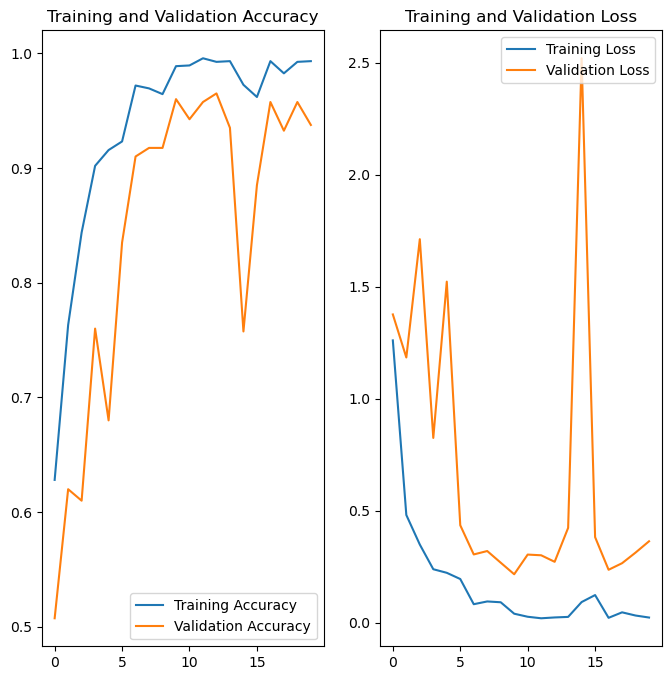

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(r'A:\\MSc\\Pulmonary Nodules\\figures\\'  + model_name + '.png')
plt.show()

# Extracting results

## Testing Helper Functions

In [20]:
 def get_testing_data(radius, start = 1200, n = 200, size = (64,64,28), levels=['normal', 1, 5], criteria = 'mixed'):
    h,w,d = size  
    data = []
    label = []
    
    if criteria == 'mixed': # normal vs mix malignant and benign volumes (labeled as "contain nodules")
        level = levels[0]
        for i in tqdm(range(start, start+n)):
            try:
                data.append(normalize_volume(np.load(_get_path(radius, level, i))).reshape(h,w,d,1))
                label.append(0)
            except:
                continue
        
        level = levels[1]
        for i in tqdm(range(start, start+int(n/2))):
            try:
                data.append(normalize_volume(np.load(_get_path(radius, level, i))).reshape(h,w,d,1))
                label.append(1)
            except:
                continue
                
        level = levels[2]
        for i in tqdm(range(start, start+int(n/2))):
            try:
                data.append(normalize_volume(np.load(_get_path(radius, level, i))).reshape(h,w,d,1))
                label.append(1)
            except:
                continue
               
    elif criteria == 'binary' : # normal vs malignant or normal vs benign
        for level in levels:
            for i in tqdm(range(start, start+n)):
                try:
                    data.append(normalize_volume(np.load(_get_path(radius, level, i))).reshape(h,w,d,1))
                except :
                    continue
                if level == 'normal':
                    label.append(0)
                else :
                    label.append(1)
                    
    elif criteria == 'binary_nodules':
        for level in levels:
            for i in tqdm(range(start, start+n)):
                try:
                    data.append(normalize_volume(np.load(_get_path(radius, level, i))).reshape(h,w,d,1))
                except :
                    continue
                if level == 1:
                    label.append(0)
                elif level == 5 :
                    label.append(1)
                    
    elif criteria == 'three classes': # three classes for classification normal vs ben vs mal
        for level in levels:
            for i in tqdm(range(start, start+n)):
                try:
                    data.append(normalize_volume(np.load(_get_path(radius, level, i))).reshape(h,w,d,1))
                except :
                    continue
                if level == 'normal':
                    label.append(0)
                elif level == 1 :
                    label.append(1)
                elif level == 5:
                    label.append(2)
        
    return data, label

def test_data_prep(data, labels, BATCH_SIZE = 16, n_classes = 1):
    if n_classes == 1:
        dataset = tf.data.Dataset.from_tensor_slices((data, labels))
        dataset = dataset.batch(BATCH_SIZE)
    else :
        labels = tf.keras.utils.to_categorical(labels, 3)
        dataset = tf.data.Dataset.from_tensor_slices((data, labels))
        dataset = dataset.batch(BATCH_SIZE)
    return dataset

classification_problem = ['normal_vs_malignant', 'normal_vs_benign', 'normal_vs_mixed', 'benign_vs_malignant', 'normal_vs_benign_vs_malignant']
model_groups = [['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50'],
               ['normal_vs_benign_r10', 'normal_vs_benign_r20', 'normal_vs_benign_r30', 'normal_vs_benign_r40', 'normal_vs_benign_r50'],
               ['normal_vs_mixed_r10', 'normal_vs_mixed_r20', 'normal_vs_mixed_r30', 'normal_vs_mixed_r40', 'normal_vs_mixed_r50'],
               ['benign_vs_malignant_r10', 'benign_vs_malignant_r20', 'benign_vs_malignant_r30', 'benign_vs_malignant_r40', 'benign_vs_malignant_r50'],
               ['normal_vs_benign_vs_malignant_r10', 'normal_vs_benign_vs_malignant_r20', 'normal_vs_benign_vs_malignant_r30', 'normal_vs_benign_vs_malignant_r40', 'normal_vs_benign_vs_malignant_r50']
              ]


In [4]:
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}

for prob, group in tqdm(zip(classification_problem, model_groups), total = len(classification_problem)):
    
    if prob == 'normal_vs_malignant':
        levels = ['normal', 5]
        criteria = 'binary'
        n_classes = 1
    if prob == 'normal_vs_benign':
        levels = ['normal', 1]
        criteria = 'binary'
        n_classes = 1
    if prob == 'normal_vs_mixed':
        levels = ['normal', 1, 5]
        criteria = 'mixed'
        n_classes = 1
    if prob == 'benign_vs_malignant':
        levels = [1, 5]
        criteria = 'binary_nodules'
        n_classes = 1
    if prob == 'normal_vs_benign_vs_malignant':
        levels = ['normal', 1, 5]
        criteria = 'three classes'
        n_classes = 3
    
        
    for m_name in group:
        results[m_name] = []
        _path = models_path + m_name
        m = tf.keras.models.load_model(_path)

        for r in radii:
            data, labels = get_testing_data(r, start = 1000, n = 200, size = (64,64,28), levels=levels, criteria = criteria)
            test_data =  test_data_prep(data, labels, BATCH_SIZE = 16, n_classes = n_classes)
            r = m.evaluate(test_data)
            results[m_name].append(r[1])   

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 5s 107ms/step - loss: 1.3894 - accuracy: 0.7750


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 1.4604 - accuracy: 0.7375


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 2.8221 - accuracy: 0.6050


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 4.1647 - accuracy: 0.5025


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 4.9551 - accuracy: 0.4625


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 5.1005 - accuracy: 0.4525


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 106ms/step - loss: 5.1852 - accuracy: 0.3800


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 4.7801 - accuracy: 0.3725


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 4.5414 - accuracy: 0.3600


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 4.4753 - accuracy: 0.4150


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 3.0564 - accuracy: 0.5225


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 2.8974 - accuracy: 0.5425


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 1.8577 - accuracy: 0.7100


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 1.7240 - accuracy: 0.6125


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 1.4037 - accuracy: 0.6500


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 1.8764 - accuracy: 0.5625


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 2.0422 - accuracy: 0.5900


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 3.1389 - accuracy: 0.4550


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 2.8209 - accuracy: 0.4350


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 2.3539 - accuracy: 0.5375


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 109ms/step - loss: 4.0627 - accuracy: 0.4150


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 3.2195 - accuracy: 0.4625


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 109ms/step - loss: 2.4428 - accuracy: 0.5500


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 109ms/step - loss: 2.6314 - accuracy: 0.6275


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 2.3720 - accuracy: 0.6050


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 109ms/step - loss: 2.2338 - accuracy: 0.6850


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 2.6890 - accuracy: 0.6250


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 3.3931 - accuracy: 0.4775


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 3.6940 - accuracy: 0.3925


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 2.9005 - accuracy: 0.4975


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 3.3450 - accuracy: 0.4550


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 3.2872 - accuracy: 0.4350


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 3.9601 - accuracy: 0.4200


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 3.0886 - accuracy: 0.4675


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 2.2352 - accuracy: 0.5550


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 1.9599 - accuracy: 0.5325


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 2.2439 - accuracy: 0.6325


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 2.9470 - accuracy: 0.6575


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 106ms/step - loss: 3.4815 - accuracy: 0.6175


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 2.1472 - accuracy: 0.5625


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 3.1515 - accuracy: 0.4575


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 2.7467 - accuracy: 0.5050


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 3.1660 - accuracy: 0.4950


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 3.1961 - accuracy: 0.5350


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 2.8889 - accuracy: 0.5050


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 2.4059 - accuracy: 0.5250


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 2.4945 - accuracy: 0.5300


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 2.9421 - accuracy: 0.5275


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 107ms/step - loss: 3.1648 - accuracy: 0.5300


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 3s 108ms/step - loss: 1.9974 - accuracy: 0.6025


In [5]:
pd.DataFrame(results).to_csv(r'A:\MSc\Pulmonary Nodules\Results/benign_vs_malignant.csv')

# Normal vs Malignant Heatmap

In [2]:
data_info = pd.read_csv(r'A:\MSc\Pulmonary Nodules\sameslicethickness\arranged\arranged_info.csv')

In [3]:
target = 'nodule_diameter'
n = np.unique(np.array(data_info['nodule_diameter'])).shape[0]
nodule_diameters = np.unique(np.array(data_info['nodule_diameter']))
print(f'there are {n} different nodule diameters')

there are 292 different nodule diameters


## Helper functions

In [6]:
def create_v_path(r, l, vn):
    path = f'A:/MSc/Pulmonary Nodules/sameslicethickness/arranged/radius_{r}/level_{l}/' + vn + '.npy'
    return path

def get_vn(vname):
    return int(vname.split('v')[-1])

def normalize_volume(volume):
    return (volume-volume.min())/(volume.max()-volume.min())

def test_data_prep(data, labels, BATCH_SIZE = 16):
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def load_data(df, malignancy_score, c):
    h, w, d = (64, 64, 28)
    data = []
    label = []
    vs = list(df['volume'])
    rs = list(df['radius'])
    for v, r in zip(vs, rs):
        if  get_vn(v) > 1000: # to get samples from testing data only
            data.append(normalize_volume(np.load(create_v_path(int(r), malignancy_score, v))).reshape(h,w,d,1))
            label.append(c)
            if len(data) > 100:
                break
    dataset = test_data_prep(data, label, 16)
    return dataset

## number of malignant | benign nodules vs nodule diameter

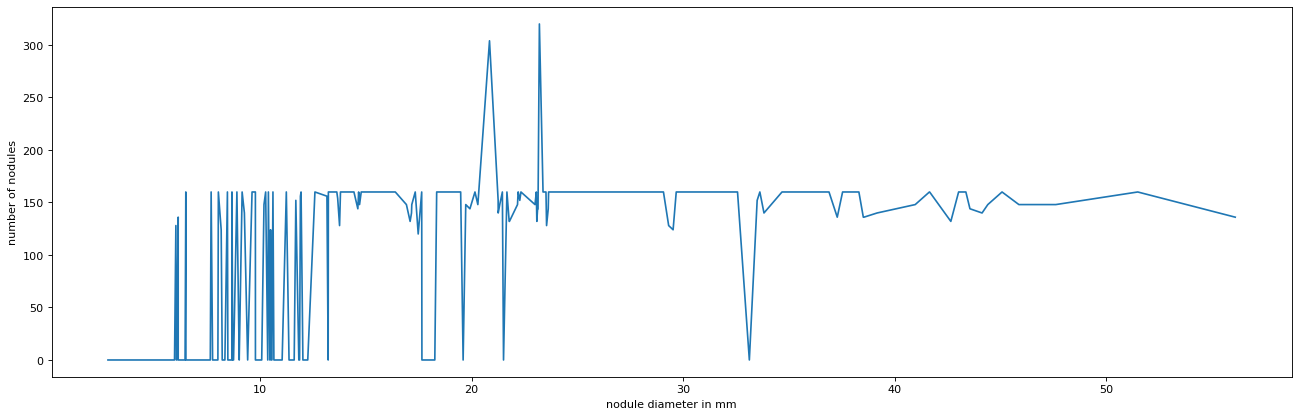

In [65]:
# getting number of malignant nodules that has a certain size
size_n_nodules = []
for size in nodule_diameters:
    n_nodules = len(data_info.loc[data_info['nodule_diameter'] == size].loc[data_info['malignancy_score']==5])
    size_n_nodules.append([size, n_nodules])
size_n_nodules = np.array(size_n_nodules)
plt.figure(figsize=(20, 6), dpi=80)
plt.xlabel('nodule diameter in mm')
plt.ylabel('number of nodules')
plt.plot(size_n_nodules[:,0], size_n_nodules[:,1])

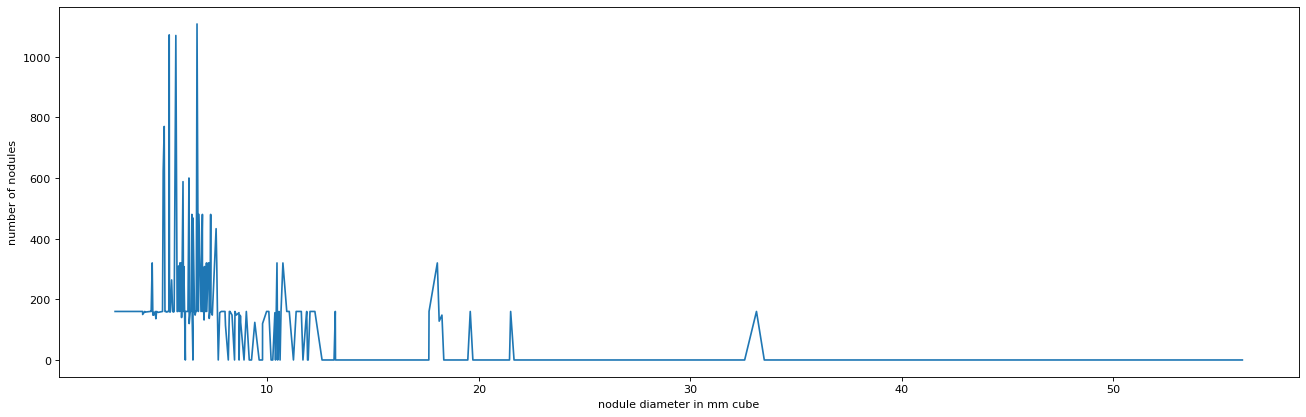

In [66]:
# getting number of benign nodules that has a certain size
size_n_nodules = []
for size in nodule_diameters:
    n_nodules = len(data_info.loc[data_info['nodule_diameter'] == size].loc[data_info['malignancy_score']==1])
    size_n_nodules.append([size, n_nodules])
size_n_nodules = np.array(size_n_nodules)
plt.figure(figsize=(20, 6), dpi=80)
plt.xlabel('nodule diameter in mm cube')
plt.ylabel('number of nodules')
plt.plot(size_n_nodules[:,0], size_n_nodules[:,1])

## Group per diameter and test

### Number of samples per group

In [5]:
malignancy_score = 5
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
noduleD_r_nSamples = {}
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
# number of nodules that ranges from 50 to 60 is too small to determine accuracy.

for r in radii:
    noduleD_r_nSamples[f'r{r}'] = {}
    for d1, d2 in zip(small_d, large_d):
        data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
            data_info['malignancy_score']==malignancy_score].loc[data_info['radius'] == r]
        n_samples = 0
        for vname in list(data_df['volume']):
            if get_vn(vname) > 1000:
                n_samples += 1
        noduleD_r_nSamples[f'r{r}'][f'{d1}  < d <= {d2}'] = n_samples

In [6]:
pd.DataFrame(noduleD_r_nSamples)

,r5,r10,r15,r20,r25,r30,r35,r40,r45,r50
0 < d <= 10,160,156,152,152,148,148,141,136,136,131
10 < d <= 20,372,368,368,354,352,344,340,322,322,322
20 < d <= 30,399,399,399,378,377,373,365,348,326,313
30 < d <= 40,359,359,359,359,347,339,339,339,335,335
40 < d <= 60,205,205,205,200,199,195,190,172,170,168


### Test

#### All at once (kernel dies)

In [ ]:
malignancy_score = 5
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
# number of nodules that ranges from 50 to 60 is too small to determine accuracy.
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
for m_name in tqdm(models, total = len(models)):
    results[m_name] = {}
    _path = models_path + m_name
    m = tf.keras.models.load_model(_path)
    for r in tqdm(radii, total = len(radii)):
        results[m_name][f'r{r}'] = {}
        for d1, d2 in zip(small_d, large_d):
            data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
                data_info['malignancy_score']==malignancy_score].loc[data_info['radius'] == r]
            test_data = load_data(data_df, malignancy_score, 1)
            accuracy = m.evaluate(test_data)
            results[m_name][f'r{r}'][f'{d1}  < d <= {d2}'] = accuracy[1]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

#### normal_vs_malignant_r10

In [12]:
malignancy_score = 5
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
#
m_name = 'normal_vs_malignant_r10'
_path = models_path + m_name
m = tf.keras.models.load_model(_path)

In [ ]:
results[m_name] = {}
for r in tqdm(radii, total = len(radii)):
    print(f'radius is  {r}')
    results[m_name][f'r{r}'] = {}
    for d1, d2 in zip(small_d, large_d):
        print(f'{d1}   ->    {d2}')
        data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
            data_info['malignancy_score']==malignancy_score].loc[data_info['radius'] == r]
        test_data = load_data(data_df, malignancy_score, 1)
        # accuracy = m.evaluate(test_data)
        # results[m_name][f'r{r}'][f'{d1}  < d <= {d2}'] = accuracy[1]

  0%|          | 0/10 [00:00<?, ?it/s]

radius is  5
0   ->    10


In [6]:
data_df = data_info.loc[data_info['nodule_diameter'] > 0].loc[data_info['nodule_diameter'] <= 10].loc[
            data_info['malignancy_score']==5].loc[data_info['radius'] == 10]
data_df.head()

,Unnamed: 0,volume,pid,malignancy_score,nodule_centroid,volume_centroid,radius,nodule_diameter,nodule_volume
9005,9005,v87,LIDC-IDRI-0590,5.0,[252.36121673 416.2243346 258.00380228],[252. 416. 268.],10.0,9.140625,174.425125
9006,9006,v88,LIDC-IDRI-0590,5.0,[252.36121673 416.2243346 258.00380228],[252. 416. 268.],10.0,9.140625,174.425125
9007,9007,v89,LIDC-IDRI-0590,5.0,[252.36121673 416.2243346 258.00380228],[252. 416. 268.],10.0,9.140625,174.425125
9008,9008,v90,LIDC-IDRI-0590,5.0,[252.36121673 416.2243346 258.00380228],[252. 416. 268.],10.0,9.140625,174.425125
9009,9009,v91,LIDC-IDRI-0590,5.0,[252.36121673 416.2243346 258.00380228],[262. 416. 258.],10.0,9.140625,174.425125


In [ ]:
test_data = load_data(data_df, 5, 1)

In [7]:
h, w, d = (64, 64, 28)
data = []
label = []
vs = list(data_df['volume'])
rs = list(data_df['radius'])
for v, r in tqdm(zip(vs, rs), total = len(vs)):
    if  get_vn(v) > 1000: # to get samples from testing data only
        data.append(normalize_volume(np.load(create_v_path(int(r), 5, v))).reshape(h,w,d,1))
        label.append(label)
#dataset = test_data_prep(data, label, 16)

  0%|          | 0/204 [00:00<?, ?it/s]

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((data, label))

# AUC

In [25]:
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
_path = models_path + models[2]
m = tf.keras.models.load_model(_path)
m.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])

In [60]:
# variables
r = 50
l = ['normal', 5]
c = 'binary'
n_classes = 1
model_name = 'normal_vs_malignant_r50'
bs = 16
epochs = 20
# done
_path = models_path + model_name
m = tf.keras.models.load_model(_path)
m.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])

In [61]:
data, labels = get_testing_data(r, start = 1000, n = 200, size = (64,64,28), levels=l, criteria = c)
test_data =  test_data_prep(data, labels, BATCH_SIZE = 16, n_classes = n_classes)
m.evaluate(test_data)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

25/25 [==============================] - 5s 169ms/step - loss: 0.8906 - auc_19: 0.9146


[0.8906364440917969, 0.9146499037742615]

In [ ]:
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}

for prob, group in tqdm(zip(classification_problem, model_groups), total = len(classification_problem)):
    
    if prob == 'normal_vs_malignant':
        levels = ['normal', 5]
        criteria = 'binary'
        n_classes = 1
    if prob == 'normal_vs_benign':
        levels = ['normal', 1]
        criteria = 'binary'
        n_classes = 1
    if prob == 'normal_vs_mixed':
        levels = ['normal', 1, 5]
        criteria = 'mixed'
        n_classes = 1
    if prob == 'benign_vs_malignant':
        levels = [1, 5]
        criteria = 'binary_nodules'
        n_classes = 1
    if prob == 'normal_vs_benign_vs_malignant':
        levels = ['normal', 1, 5]
        criteria = 'three classes'
        n_classes = 3
    
        
    for m_name in group:
        results[m_name] = []
        _path = models_path + m_name
        m = tf.keras.models.load_model(_path)
        m.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])

        data, labels = get_testing_data(r, start = 1000, n = 200, size = (64,64,28), levels=levels, criteria = criteria)
        test_data =  test_data_prep(data, labels, BATCH_SIZE = 16, n_classes = n_classes)
        r = m.evaluate(test_data)
        results[m_name].append(r[1])  